In [ ]:
# Kaggle Surface Crack Detection - 콘크리트 표면 결함 (Surface Crack Detection) 이미지 분류

# 콘크리트 표면 결함 (Surface Crack Detection)을 발견하고 예측하기 위한 Kaggle의 공개 데이터로서 
# 평균적으로 227x227 크리를 가지는 color 이미지이며, crack 없는 Negative 데이터 2만개와 crack 발생한 Positive 데이터 2만개
# 총 4만 개의 이미지 데이터

# Conv Layer -> MaxPooling Layer -> Conv Layer -> MaxPooling Layer -> Conv Layer -> MaxPooling Layer
# -> Flatten Layer -> Linear -> Linear
# 데이터 다운로드 및 로드 -> 데이터 전처리(정규화 Normalization) -> 모델 아키텍처 구성 -> 모델 학습 및 평가

In [1]:
# 라이브러리
import os, shutil, glob, cv2, zipfile, random
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

# GPU 설정
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('pytorch version : ', torch.__version__, ', device : ', DEVICE)

pytorch version :  2.2.2 , device :  cpu


In [2]:
# ===============================
# 데이터 경로 설정
# ===============================
ROOT_DIR = './data'
DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'surface_crack')
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'train')
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'test')

In [ ]:
# 데이터 폴더 존재시 삭제
if os.path.exists('./data/surface_crack'):
    shutil.rmtree('./data/surface_crack')
    print('./data/surface_crack is removed')

.\data\GTSRB is removed


In [ ]:
# 압축 해제
with zipfile.ZipFile(os.path.join(ROOT_DIR, 'surface_crack.zip'), 'r') as target_file:
    target_file.extractall(DATA_ROOT_DIR)

In [ ]:
# 데이터 전처리 - 원본 데이터 확인
# - Negative, Positive 디렉토리는 이미지 정답(label)을 나타내며, 해당 디렉토리에 정답에 해당하는 이미지가 들어 있음
# - 총 2개의 정답을 가지는 이미지가 학습데이터임

label_name_list = os.listdir(DATA_ROOT_DIR)
print(DATA_ROOT_DIR)
print(label_name_list, len(label_name_list))

for label_name in label_name_list:

    label_dir = os.path.join(DATA_ROOT_DIR, label_name)
    print('train label : ' + label_name + ' => ', len(os.listdir(os.path.join(DATA_ROOT_DIR,label_name))))

./data/surface_crack
['Positive', 'Negative'] 2
train label : Positive =>  20000
train label : Negative =>  20000


In [14]:
# 데이터 전처리 - copytree 이용해서 Positive, Negative 모든 내용을 train 디렉토리 아래로 동일한 이름의 디렉토리로 복사함

try:
    shutil.copytree(DATA_ROOT_DIR, TRAIN_DATA_ROOT_DIR)
except Exception as err:
    print(str(err))

In [15]:
# 데이터 전처리 - surface_crack/test 디렉토리 생성, surface_crack/test/Positive, Negative 디렉토리 생성

# test dir 생성
if not os.path.exists(TEST_DATA_ROOT_DIR):
    os.mkdir(TEST_DATA_ROOT_DIR)
    print(TEST_DATA_ROOT_DIR + ' is created !')
else:
    print(TEST_DATA_ROOT_DIR + ' already exists ')

# test/Positive 생성
if not os.path.exists(os.path.join(TEST_DATA_ROOT_DIR, 'Positive')):
    os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, 'Positive'))
    print(os.path.join(TEST_DATA_ROOT_DIR, 'Positive') + ' is created !')
else:
    print(os.path.join(TEST_DATA_ROOT_DIR, 'Positive') + ' already exists ')

# test/Negative 생성
if not os.path.exists(os.path.join(TEST_DATA_ROOT_DIR, 'Negative')):
    os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, 'Negative'))
    print(os.path.join(TEST_DATA_ROOT_DIR, 'Negative') + ' is created !')
else:
    print(os.path.join(TEST_DATA_ROOT_DIR, 'Negative') + ' already exists ')

./data/surface_crack/test is created !
./data/surface_crack/test/Positive is created !
./data/surface_crack/test/Negative is created !


In [16]:
# 데이터 전처리 - move 비율 설정
MOVE_RATIO = 0.2 # train : test = 80 : 20, train 데이터 20% 데이터를 test 데이터로 사용

In [ ]:
# 데이터 전처리 -  파일 move train_data_dir => test_data_dir

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(label_name_list)

for label_name in label_name_list:
    src_dir_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    dst_dir_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)

    train_data_file_list = os.listdir(src_dir_path)
    print(label_name, len(train_data_file_list))

    # data shuffle
    random.shuffle(train_data_file_list)
    
    split_num = int(MOVE_RATIO * len(train_data_file_list))
    print(split_num)

    test_data_file_list = train_data_file_list[0:split_num]

    move_nums = 0
    for test_data_file in test_data_file_list:
        try:
            shutil.move(os.path.join(src_dir_path, test_data_file),
                        os.path.join(dst_dir_path, test_data_file))
        except Exception as err:
            print(str(err))
        
        move_nums = move_nums + 1
    
    print('total move nums => ', move_nums)

['Positive', 'Negative']
Positive 20000
4000
total move nums =>  4000
Negative 20000
4000
total move nums =>  4000


In [24]:
# 데이터 전처리 - 데이터 확인 train/Positive, train/Negative 파일 개수 확인, test/Positive, test/Negative 파일 개수 확인

# train
label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(TRAIN_DATA_ROOT_DIR)
print(label_name_list, len(label_name_list))

for label_name in label_name_list:

    label_dir = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    print('train label : ' + label_name + ' => ', len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR,label_name))))

# test
label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(TEST_DATA_ROOT_DIR)
print(label_name_list, len(label_name_list))

for label_name in label_name_list:

    label_dir = os.path.join(TEST_DATA_ROOT_DIR, label_name)
    print('test label : ' + label_name + ' => ', len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR,label_name))))

./data/surface_crack/train
['Positive', 'Negative'] 2
train label : Positive =>  16000
train label : Negative =>  16000
./data/surface_crack/test
['Positive', 'Negative'] 2
test label : Positive =>  4000
test label : Negative =>  4000


In [25]:
# ===============================
# Dataset 준비
# ===============================
IMG_WIDTH, IMG_HEIGHT = 128, 128
BATCH_SIZE = 32

# transforms 설정
train_transforms = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet 기준 정규화
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# datasets.ImageFolder
train_dataset = datasets.ImageFolder(TRAIN_DATA_ROOT_DIR, transform=train_transforms)
test_dataset = datasets.ImageFolder(TEST_DATA_ROOT_DIR, transform=test_transforms)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 정답 label
class_names = train_dataset.classes
print('클래스 : ', class_names)

클래스 :  ['Negative', 'Positive']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.0455183..2.0125492].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5356624..1.8683473].


torch.Size([32, 3, 128, 128]) torch.Size([32])
{0: 'Negative', 1: 'Positive'}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.95342064..2.235994].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7240347..2.5179958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5014129..2.1171243].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.3802522..1.6813945].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6726604..2.3760502].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4842881..2.3060222].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.3802522.

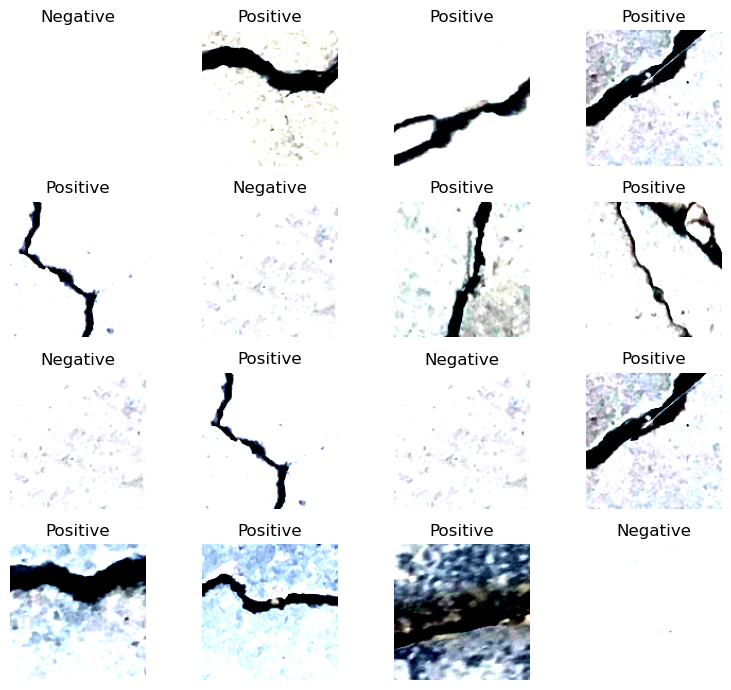

In [26]:
# 1개 배치 추출
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

# labels map 생성
labels_map = { v : k for k, v in train_dataset.class_to_idx.items() }
print(labels_map)

# 이미지 시각화
plt.figure(figsize=(8, 7))
cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1, )).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    plt.subplot(rows, cols, i)
    plt.imshow(torch.permute(img, (1, 2, 0)))
    plt.title(labels_map[label])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [31]:
# ======================
# CNN 모델 정의
# Conv Layer -> MaxPooling Layer -> Conv Layer -> MaxPooling Layer -> Conv Layer -> MaxPooling Layer
# -> Flatten Layer -> Linear -> Linear
# 데이터 다운로드 및 로드 -> 데이터 전처리(정규화 Normalization) -> 모델 아키텍처 구성 -> 모델 학습 및 평가
# ======================
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=0), # 128x128
            nn.ReLU(),
            nn.MaxPool2d(2), # 64x64
            nn.Dropout(0.25),
            nn.Conv2d(32, 64, kernel_size=3, padding=0), # 64x64
            nn.ReLU(),
            nn.MaxPool2d(2), # 32x32
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size=3, padding=0), # 32x32
            nn.ReLU(),
            nn.MaxPool2d(2), # 16x16
            nn.Dropout(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 14 * 14, 512),  # 32x32 → conv(3x3)x2 → 28x28 → pool(2x2) → 14x14
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [32]:
# ======================
# 모델객체 & 손실함수 & 옵티마이저
# ======================
n_classes = len(class_names)
model = CNNModel(n_classes).to(DEVICE)
print(model)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=25088, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
)


In [33]:
# ===============================
# 학습 함수
# ===============================
def train_model(model, loss_function, optimizer, train_loader, val_loader, num_epochs, patience=5):
    best_loss = np.inf
    counter = 0
    train_acc_hist, val_acc_hist = [], []
    train_loss_hist, val_loss_hist = [], []

    for epoch in range(num_epochs):
        # --- Train ---
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad() # 미분 초기화
            outputs = model(inputs) # 모델 예측
            loss = loss_function(outputs, labels) # 손실함수 계산

            _, preds = torch.max(outputs, 1) # 예측값 분리
            loss.backward() # 미분 연산
            optimizer.step() # 미분 연산 후 파라미터(가중치, 바이어스) 업데이트

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset) # 평균 손실함수값
        epoch_acc = running_corrects.double() / len(train_loader.dataset) # 평균 정확도값
        train_loss_hist.append(epoch_loss)
        train_acc_hist.append(epoch_acc.item())

        # --- Validation ---
        model.eval()
        val_running_loss, val_running_corrects = 0.0, 0

        with torch.no_grad(): # 오차역전파 사용 안함, 미분 연산 하지 않음
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs) # 모델 예측
                loss = loss_function(outputs, labels) # 손실함수값 계산

                _, preds = torch.max(outputs, 1) # 예측값 분리
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        val_loss = val_running_loss / len(val_loader.dataset) # validation 평균 손실함수값
        val_acc = val_running_corrects.double() / len(val_loader.dataset) # validation 평균 정확도값
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_acc.item())

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f} "
              f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered")
                model.load_state_dict(best_model_wts)
                break

    return model, (train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist)

In [35]:
# ===============================
# 학습 실행
# ===============================
model, history = train_model(model, loss_function, optimizer, train_loader, test_loader, num_epochs=5)

Epoch 1/5 - Train loss: 0.0270, acc: 0.9919 Val loss: 0.0366, acc: 0.9916
Epoch 2/5 - Train loss: 0.0218, acc: 0.9932 Val loss: 0.0247, acc: 0.9934
Epoch 3/5 - Train loss: 0.0170, acc: 0.9949 Val loss: 0.0254, acc: 0.9934
Epoch 4/5 - Train loss: 0.0143, acc: 0.9957 Val loss: 0.0172, acc: 0.9949
Epoch 5/5 - Train loss: 0.0121, acc: 0.9962 Val loss: 0.0138, acc: 0.9960


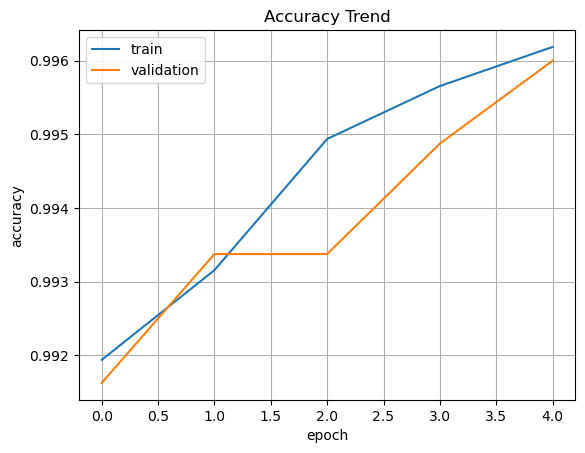

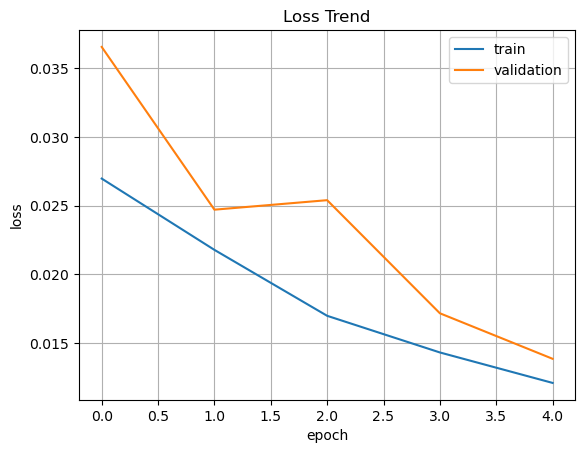

In [37]:
# ======================
# 정확도 및 손실 그래프
# ======================
train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist = history

plt.plot(train_acc_hist, label='train')
plt.plot(val_acc_hist, label='validation')
plt.title('Accuracy Trend')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()

plt.plot(train_loss_hist, label='train')
plt.plot(val_loss_hist, label='validation')
plt.title('Loss Trend')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Save the model checkpoint
torch.save(model.state_dict(), './models/model_cnn_surface_crack_detection.ckpt')

RuntimeError: Parent directory .\models does not exist.

In [63]:
# ===============================
# 테스트 성능 평가
# ===============================
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 99.59%
